In [1]:
import json
import os
import random
import time
from pathlib import Path
import shutil

import cv2

import load_data_functions as ld
import preprocess_functions as pf
import train_test_split_functions as tts

In [2]:
# setup data paths
data_path = Path("data")
image_path = data_path / "valence"

In [3]:
# extract zip files if they are not already extracted
zip_action = ld.extract_zip_files(data_path, image_path)
print(zip_action)

Currently extracting file data\01.zip
Currently extracting file data\02.zip
Currently extracting file data\03.zip
Currently extracting file data\04.zip
Currently extracting file data\05.zip
Currently extracting file data\06.zip
Currently extracting file data\07.zip
Currently extracting file data\08.zip
Currently extracting file data\09.zip
Currently extracting file data\10.zip
Currently extracting file data\11.zip
Currently extracting file data\12.zip
Created data\valence directory and unzipped files.


In [4]:
# detect faces and align them as was done in Savchenko et al. (2022)
new_dir = data_path / "aligned"
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
    print(f"Dir {new_dir} was created.")

    folders = ld.get_folder_paths(image_path)

    for folder in folders:
        start_time = time.time()
        img_paths = list(folder.glob("*.png"))
        new_folder_path = new_dir / folder.name
        if not os.path.exists(new_folder_path):
            os.makedirs(new_folder_path)

        # detect landmarks and align faces
        for img_path in img_paths:
            img = cv2.imread(str(img_path))
            _, _, landmarks = pf.check_for_face_in_img(img, keep_all=False)

            # align faces if landmarks were detected and save the aligned image
            if landmarks is not None:
                aligned = pf.align_face(img, landmarks[0])
                new_img_path = f"{new_folder_path}/{img_path.name}"
                cv2.imwrite(new_img_path, aligned)

        # get number of detected faces
        img_paths_aligned = list(new_folder_path.glob("*.png"))
        if len(img_paths_aligned) == 0:
            print(f"Deleting folder {folder} as it contains no aligned images.")
            shutil.rmtree(new_folder_path)
            continue

        # copy labels
        file = f"{folder.name}.json"
        json_folder_path = folder / file
        destination = new_folder_path / file
        shutil.copy2(json_folder_path, destination)

        end_time = time.time()
        print(f"Duration for folder {folder}: {end_time-start_time}")
else:
    print(f"Dir {new_dir} already exists.")

Dir data\aligned was created.
Duration for folder data\valence\001: 4.388434648513794
Duration for folder data\valence\002: 4.439924001693726
Duration for folder data\valence\003: 2.763017416000366
Duration for folder data\valence\004: 1.5112264156341553
Duration for folder data\valence\005: 1.516824722290039
Duration for folder data\valence\006: 3.176363229751587
Duration for folder data\valence\007: 3.167666435241699
Duration for folder data\valence\008: 7.911978483200073
Duration for folder data\valence\009: 2.057074785232544
Duration for folder data\valence\010: 3.4106481075286865
Duration for folder data\valence\011: 9.693922758102417
Duration for folder data\valence\012: 2.603614091873169
Duration for folder data\valence\013: 3.5013091564178467
Duration for folder data\valence\014: 5.721011161804199
Duration for folder data\valence\015: 2.1090033054351807
Duration for folder data\valence\016: 4.812883377075195
Duration for folder data\valence\017: 4.858962535858154
Duration for f

Retrieving images...
The aligned-folder contains 909 images less than the original data folder.
Retrieving image labels...
Comparing label distribution...
         raw_labels  aligned_labels
count  30051.000000    29142.000000
mean      -1.241456       -1.223972
std        2.779279        2.782047
min      -10.000000      -10.000000
25%       -3.000000       -3.000000
50%       -1.000000       -1.000000
75%        0.000000        0.000000
max        8.000000        8.000000


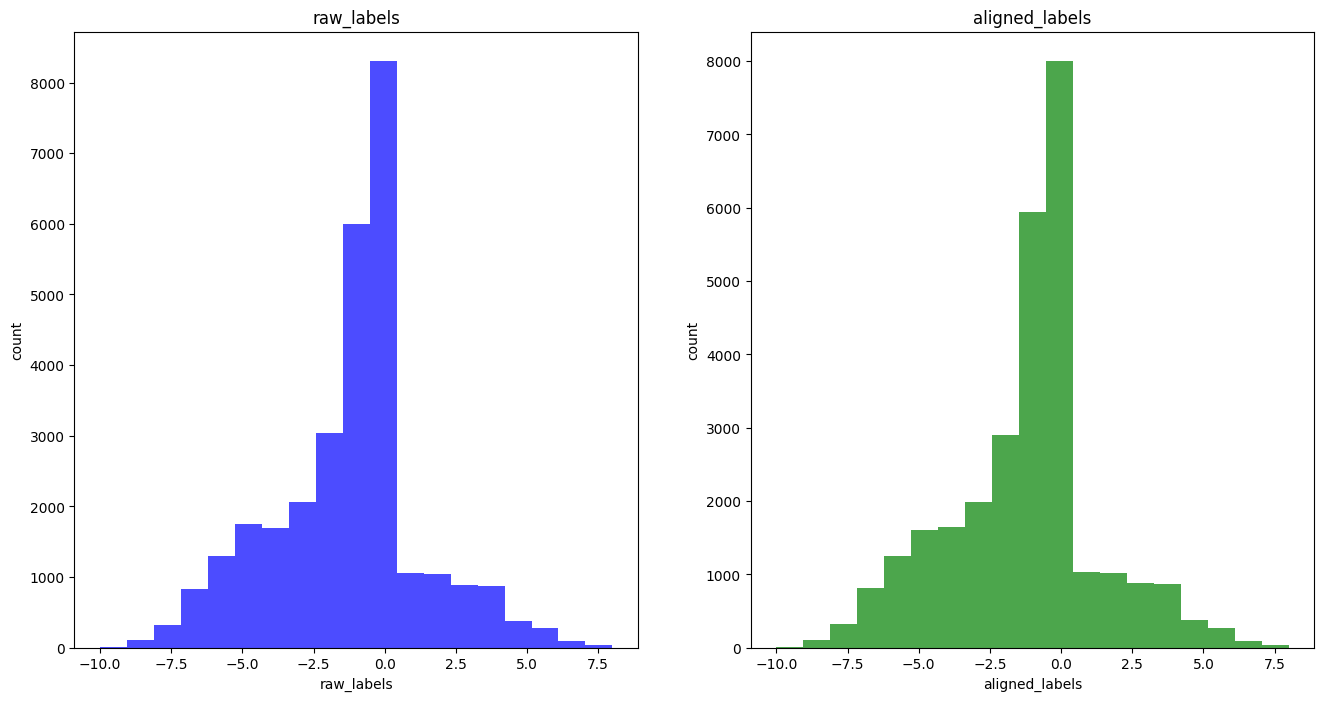

In [5]:
# compare the label distribution of the raw images and the aligned images
aligned_path = Path("data/aligned")
raw_folders = ld.get_folder_paths(image_path)
aligned_folders = ld.get_folder_paths(aligned_path)

print("Retrieving images...")
raw_images = tts.find_all_ims(raw_folders)
aligned_images = tts.find_all_ims(aligned_folders)
print(f"The aligned-folder contains {len(raw_images) - len(aligned_images)} images less than the original data folder.")

print("Retrieving image labels...")
raw_labels = ld.get_all_image_labels(raw_images)
aligned_labels = ld.get_all_image_labels(aligned_images)

print("Comparing label distribution...")
df_compared = ld.compare_distributions(raw_labels, aligned_labels, "raw_labels",
                                       "aligned_labels", save_results=True, show=True)

Observations
* both distributions are fairly similar
* it was not possible to align 909 images 

In [6]:
# find a train-test split, where the test set contains approximately 15% of images
aligned_path = Path("data/aligned")
test_percentage = 0.15

folder_paths = ld.get_folder_paths(aligned_path)
test_folders, train_folders = tts.find_correct_percentage(test_percentage, folder_paths, validation_fold=False)

For the seed = 4, the percentage of selected images is approximately 0.15


In [7]:
# perform the train-test split and create the folders
split_path = Path("data/train_test_split")
if not split_path.exists():
    split_path.mkdir(parents=True, exist_ok=True)

test_path = split_path / "test"
train_path = split_path / "train"

tts.copy_folders(aligned_path, test_path, test_folders)
tts.copy_folders(aligned_path, train_path, train_folders)

Copying folders...
89 folders were successfully copied to data\train_test_split\test.
Copying folders...
506 folders were successfully copied to data\train_test_split\train.


In [8]:
# create the validation folds
num_folds = 5
validation_percentage = 0.20
train_folders = ld.get_folder_paths(train_path)

fold_1, not_selected = tts.find_correct_percentage(validation_percentage, train_folders)
print(f"Fold 1 was selected. Length of fold 1: {len(fold_1)}")
fold_2, not_selected_2 = tts.find_correct_percentage(validation_percentage, not_selected)
print(f"Fold 2 was selected. Length of fold 2: {len(fold_2)}")
fold_3, not_selected_3 = tts.find_correct_percentage(validation_percentage, not_selected_2)
print(f"Fold 3 was selected. Length of fold 3: {len(fold_3)}")
fold_4, fold_5 = tts.find_correct_percentage(validation_percentage, not_selected_3)
print(f"Folds 4 and 5 were selected. Length of fold 4: {len(fold_4)}, length of fold 5: {len(fold_5)}")

For the seed = 1, the percentage of selected images is approximately 0.2
Fold 1 was selected. Length of fold 1: 101
For the seed = 0, the percentage of selected images is approximately 0.2
Fold 2 was selected. Length of fold 2: 101
For the seed = 3, the percentage of selected images is approximately 0.2
Fold 3 was selected. Length of fold 3: 101
For the seed = 0, the percentage of selected images is approximately 0.2
Folds 4 and 5 were selected. Length of fold 4: 101, length of fold 5: 102


In [9]:
# copy the folders of the five folds
fold_1_path = split_path / "fold_1"
fold_2_path = split_path / "fold_2"
fold_3_path = split_path / "fold_3"
fold_4_path = split_path / "fold_4"
fold_5_path = split_path / "fold_5"

tts.copy_folders(aligned_path, fold_1_path, fold_1)
tts.copy_folders(aligned_path, fold_2_path, fold_2)
tts.copy_folders(aligned_path, fold_3_path, fold_3)
tts.copy_folders(aligned_path, fold_4_path, fold_4)
tts.copy_folders(aligned_path, fold_5_path, fold_5)

Copying folders...
101 folders were successfully copied to data\train_test_split\fold_1.
Copying folders...
101 folders were successfully copied to data\train_test_split\fold_2.
Copying folders...
101 folders were successfully copied to data\train_test_split\fold_3.
Copying folders...
101 folders were successfully copied to data\train_test_split\fold_4.
Copying folders...
102 folders were successfully copied to data\train_test_split\fold_5.


In [10]:
# check how many images are in each fold
count_images = {}
folds_list = [test_path, train_path, fold_1_path, fold_2_path, fold_3_path, fold_4_path, fold_5_path]

for fold in folds_list:
    folders = [p for p in fold.iterdir() if p.is_dir()]
    fold_ims = tts.find_all_ims(folders)
    print(f"There are {len(fold_ims)} images in fold {fold}")

There are 4424 images in fold data\train_test_split\test
There are 24718 images in fold data\train_test_split\train
There are 4915 images in fold data\train_test_split\fold_1
There are 5015 images in fold data\train_test_split\fold_2
There are 4892 images in fold data\train_test_split\fold_3
There are 5051 images in fold data\train_test_split\fold_4
There are 4845 images in fold data\train_test_split\fold_5


In [11]:
# save the folder structure for transparency
folder_structure = {}

# Iterate through each item in the split path
for folder in split_path.iterdir():
    # Check if the path is a directory
    if folder.is_dir():
        # Get a list of subfolders
        subfolders = [subfolder.name for subfolder in folder.iterdir() if subfolder.is_dir()]
        # Add the folder and its subfolders to the dictionary
        folder_structure[folder.name] = subfolders

# Save the folder structure to a JSON file
with open('data/splits_metadata/assigned_folders.json', 'w') as json_file:
    json.dump(folder_structure, json_file, indent=4)